In [1]:
import math
import random
from dataclasses import dataclass
from typing import List, Sequence, Tuple

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

SEED = 7
torch.manual_seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Install FID calculation dependencies
!pip install -q pytorch-fid scipy

In [3]:
class MultiScaleCIFAR10(Dataset):
    """Returns RGB float pyramids for CIFAR-10."""
    def __init__(self, root: str, train: bool, scales: Sequence[int], download: bool = True):
        self.scales = list(scales)
        self.cifar10 = datasets.CIFAR10(
            root=root,
            train=train,
            download=download,
            transform=transforms.ToTensor(),
        )

    def __len__(self) -> int:
        return len(self.cifar10)

    def __getitem__(self, idx: int):
        img, label = self.cifar10[idx]
        pyramid: List[torch.Tensor] = []
        for size in self.scales:
            resized = F.interpolate(img.unsqueeze(0), size=(size, size), mode='area').squeeze(0)
            pyramid.append(resized)
        return pyramid, label


def multiscale_collate(batch):
    levels = len(batch[0][0])
    targets = [torch.stack([sample[0][level] for sample in batch], dim=0) for level in range(levels)]
    labels = torch.tensor([sample[1] for sample in batch], dtype=torch.long)
    return targets, labels


scales = [8, 16, 32]
train_dataset = MultiScaleCIFAR10(root='data', train=True, scales=scales)
test_dataset = MultiScaleCIFAR10(root='data', train=False, scales=scales)

# Set num_workers=0 to avoid multiprocessing issues in notebooks
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, collate_fn=multiscale_collate, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0, collate_fn=multiscale_collate, pin_memory=True)

len(train_dataset), len(test_dataset)

100%|██████████| 170M/170M [00:04<00:00, 42.4MB/s]


(50000, 10000)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.block(x)


class Encoder(nn.Module):
    def __init__(self, in_channels: int, hidden: int, embedding_dim: int, residual_layers: int = 2):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, hidden, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        ]
        layers.extend(ResidualBlock(hidden) for _ in range(residual_layers))
        layers.append(nn.Conv2d(hidden, embedding_dim, kernel_size=1))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, embedding_dim: int, hidden: int, out_channels: int, residual_layers: int = 2):
        super().__init__()
        layers = [nn.Conv2d(embedding_dim, hidden, kernel_size=3, padding=1), nn.ReLU(inplace=True)]
        layers.extend(ResidualBlock(hidden) for _ in range(residual_layers))
        layers.extend([
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, out_channels, kernel_size=1),
            nn.Sigmoid(),
        ])
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size: int, embedding_dim: int, beta: float = 0.25):
        super().__init__()
        self.codebook_size = codebook_size
        self.embedding_dim = embedding_dim
        self.beta = beta
        self.embedding = nn.Embedding(codebook_size, embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / codebook_size, 1.0 / codebook_size)

    def embed_code(self, indices: torch.Tensor) -> torch.Tensor:
        return self.embedding(indices).permute(0, 3, 1, 2).contiguous()

    def forward(self, z_e: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        flat_z = z_e.permute(0, 2, 3, 1).contiguous()
        distances = (
            flat_z.pow(2).sum(dim=-1, keepdim=True)
            + self.embedding.weight.pow(2).sum(dim=1)
            - 2 * torch.matmul(flat_z, self.embedding.weight.t())
        )
        encoding_indices = torch.argmin(distances, dim=-1)
        quantized = self.embed_code(encoding_indices.view(z_e.shape[0], z_e.shape[2], z_e.shape[3]))

        commitment_loss = F.mse_loss(z_e, quantized.detach())
        embedding_loss = F.mse_loss(quantized, z_e.detach())
        vq_loss = embedding_loss + self.beta * commitment_loss

        quantized = z_e + (quantized - z_e).detach()
        return quantized, encoding_indices.view(z_e.shape[0], z_e.shape[2], z_e.shape[3]), vq_loss


class ScaleVQVAE(nn.Module):
    def __init__(self, codebook_size: int = 512, embedding_dim: int = 128, hidden: int = 256, beta: float = 0.25):
        super().__init__()
        self.codebook_size = codebook_size
        self.encoder = Encoder(in_channels=3, hidden=hidden, embedding_dim=embedding_dim)
        self.vector_quantizer = VectorQuantizer(codebook_size=codebook_size, embedding_dim=embedding_dim, beta=beta)
        self.decoder = Decoder(embedding_dim=embedding_dim, hidden=hidden, out_channels=3)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        z_e = self.encoder(x)
        z_q, indices, vq_loss = self.vector_quantizer(z_e)
        reconstruction = self.decoder(z_q)
        recon_loss = F.mse_loss(reconstruction, x)
        return reconstruction, recon_loss, vq_loss, indices

    @torch.no_grad()
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z_e = self.encoder(x)
        z_q, indices, _ = self.vector_quantizer(z_e)
        return z_q, indices

    @torch.no_grad()
    def decode_from_indices(self, indices: torch.Tensor) -> torch.Tensor:
        z_q = self.vector_quantizer.embed_code(indices)
        return self.decoder(z_q)

In [5]:
@dataclass
class VQVAEConfig:
    epochs: int = 20
    lr: float = 3e-4
    grad_clip: float | None = 1.0

def train_vqvae(model: ScaleVQVAE, train_loader: DataLoader, val_loader: DataLoader, device: torch.device, config: VQVAEConfig):
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, betas=(0.9, 0.99))
    history = {'train_recon': [], 'train_vq': [], 'val_recon': [], 'val_vq': []}

    for epoch in range(1, config.epochs + 1):
        model.train()
        train_recon = 0.0
        train_vq = 0.0
        for levels, _ in tqdm(train_loader, desc=f'VQ-VAE epoch {epoch}/{config.epochs}', leave=False):
            images = levels[-1].to(device)
            optimizer.zero_grad(set_to_none=True)
            recon, recon_loss, vq_loss, _ = model(images)
            loss = recon_loss + vq_loss
            loss.backward()
            if config.grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
            optimizer.step()
            train_recon += recon_loss.item()
            train_vq += vq_loss.item()

        model.eval()
        val_recon = 0.0
        val_vq = 0.0
        with torch.no_grad():
            for levels, _ in val_loader:
                images = levels[-1].to(device)
                _, recon_loss, vq_loss, _ = model(images)
                val_recon += recon_loss.item()
                val_vq += vq_loss.item()

        train_batches = len(train_loader)
        val_batches = len(val_loader)
        train_recon /= train_batches
        train_vq /= train_batches
        val_recon /= val_batches
        val_vq /= val_batches

        history['train_recon'].append(train_recon)
        history['train_vq'].append(train_vq)
        history['val_recon'].append(val_recon)
        history['val_vq'].append(val_vq)
        print(f'VQ-VAE epoch {epoch}: recon {train_recon:.4f} | vq {train_vq:.4f} | val recon {val_recon:.4f} | val vq {val_vq:.4f}')

    return history

vqvae = ScaleVQVAE(codebook_size=512, embedding_dim=128, hidden=256, beta=0.25).to(device)
vqvae_history = train_vqvae(vqvae, train_loader, test_loader, device, VQVAEConfig())
vqvae.eval()
for param in vqvae.parameters():
    param.requires_grad_(False)

# Save VQ-VAE model
torch.save({
    'model_state_dict': vqvae.state_dict(),
    'history': vqvae_history,
    'config': {'codebook_size': 512, 'embedding_dim': 128, 'hidden': 256, 'beta': 0.25}
}, 'vqvae_cifar10.pt')
print('VQ-VAE model saved to vqvae_cifar10.pt')

VQ-VAE epoch 1/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 1: recon 0.0234 | vq 6.0586 | val recon 0.0123 | val vq 0.2646


VQ-VAE epoch 2/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 2: recon 0.0075 | vq 0.0978 | val recon 0.0050 | val vq 0.0604


VQ-VAE epoch 3/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 3: recon 0.0044 | vq 0.0479 | val recon 0.0034 | val vq 0.0315


VQ-VAE epoch 4/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 4: recon 0.0025 | vq 0.0186 | val recon 0.0018 | val vq 0.0160


VQ-VAE epoch 5/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 5: recon 0.0014 | vq 0.0096 | val recon 0.0011 | val vq 0.0066


VQ-VAE epoch 6/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 6: recon 0.0010 | vq 0.0067 | val recon 0.0009 | val vq 0.0056


VQ-VAE epoch 7/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 7: recon 0.0008 | vq 0.0050 | val recon 0.0007 | val vq 0.0039


VQ-VAE epoch 8/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 8: recon 0.0007 | vq 0.0040 | val recon 0.0006 | val vq 0.0033


VQ-VAE epoch 9/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 9: recon 0.0006 | vq 0.0036 | val recon 0.0006 | val vq 0.0032


VQ-VAE epoch 10/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 10: recon 0.0005 | vq 0.0033 | val recon 0.0005 | val vq 0.0029


VQ-VAE epoch 11/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 11: recon 0.0005 | vq 0.0030 | val recon 0.0005 | val vq 0.0029


VQ-VAE epoch 12/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 12: recon 0.0005 | vq 0.0028 | val recon 0.0005 | val vq 0.0026


VQ-VAE epoch 13/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 13: recon 0.0004 | vq 0.0027 | val recon 0.0004 | val vq 0.0022


VQ-VAE epoch 14/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 14: recon 0.0004 | vq 0.0024 | val recon 0.0004 | val vq 0.0022


VQ-VAE epoch 15/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 15: recon 0.0004 | vq 0.0023 | val recon 0.0004 | val vq 0.0020


VQ-VAE epoch 16/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 16: recon 0.0004 | vq 0.0021 | val recon 0.0003 | val vq 0.0020


VQ-VAE epoch 17/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 17: recon 0.0003 | vq 0.0020 | val recon 0.0003 | val vq 0.0017


VQ-VAE epoch 18/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 18: recon 0.0003 | vq 0.0018 | val recon 0.0003 | val vq 0.0017


VQ-VAE epoch 19/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 19: recon 0.0003 | vq 0.0018 | val recon 0.0003 | val vq 0.0017


VQ-VAE epoch 20/20:   0%|          | 0/391 [00:00<?, ?it/s]

VQ-VAE epoch 20: recon 0.0003 | vq 0.0018 | val recon 0.0003 | val vq 0.0015
VQ-VAE model saved to vqvae_cifar10.pt


In [6]:
class ScaleAutoregressiveBlock(nn.Module):
    def __init__(self, in_channels: int, hidden: int = 192, residual_layers: int = 3, num_classes: int = 512):
        super().__init__()
        layers = [nn.Conv2d(in_channels, hidden, kernel_size=3, padding=1), nn.GELU()]
        for _ in range(residual_layers):
            layers.extend([
                nn.Conv2d(hidden, hidden, kernel_size=3, padding=1),
                nn.GELU(),
                nn.Conv2d(hidden, hidden, kernel_size=1),
                nn.GELU(),
            ])
        layers.append(nn.Conv2d(hidden, num_classes, kernel_size=1))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class VisualAutoregressiveCIFAR10(nn.Module):
    """Predicts discrete VQ code indices across scales."""
    def __init__(self, scales: Sequence[int], codebook_size: int, hidden: int = 192, residual_layers: int = 3):
        super().__init__()
        self.scales = list(scales)
        self.codebook_size = codebook_size
        blocks = []
        for _ in self.scales:
            blocks.append(
                ScaleAutoregressiveBlock(
                    in_channels=3,
                    hidden=hidden,
                    residual_layers=residual_layers,
                    num_classes=codebook_size,
                )
            )
        self.blocks = nn.ModuleList(blocks)

    def forward(self, conditionings: Sequence[torch.Tensor]) -> List[torch.Tensor]:
        outputs: List[torch.Tensor] = []
        for conditioning, block in zip(conditionings, self.blocks):
            outputs.append(block(conditioning))
        return outputs

    @torch.no_grad()
    def sample(self, batch_size: int, device: torch.device, vqvae: ScaleVQVAE) -> List[torch.Tensor]:
        samples: List[torch.Tensor] = []
        conditioning = torch.zeros((batch_size, 3, self.scales[0], self.scales[0]), device=device)
        for level, (size, block) in enumerate(zip(self.scales, self.blocks)):
            logits = block(conditioning)
            probs = torch.softmax(logits, dim=1)
            dist = torch.distributions.Categorical(probs.permute(0, 2, 3, 1).reshape(-1, self.codebook_size))
            sampled = dist.sample().view(batch_size, size, size)
            samples.append(sampled)
            if level + 1 < len(self.scales):
                decoded = vqvae.decode_from_indices(sampled)
                conditioning = F.interpolate(decoded, size=(self.scales[level + 1], self.scales[level + 1]), mode='nearest')
        return samples

In [7]:
@dataclass
class TrainConfig:
    epochs: int = 35
    lr: float = 2e-3
    grad_clip: float = 1.0

def cross_entropy_2d(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return F.cross_entropy(logits, targets, reduction='mean')

def prepare_autoregressive_inputs(levels: Sequence[torch.Tensor], vqvae: ScaleVQVAE, device: torch.device):
    rgb_levels = [level.to(device) for level in levels]
    with torch.no_grad():
        level_indices: List[torch.Tensor] = []
        decoded_levels: List[torch.Tensor] = []
        for image in rgb_levels:
            _, indices = vqvae.encode(image)
            level_indices.append(indices)
            decoded_levels.append(vqvae.decode_from_indices(indices))
        conditionings: List[torch.Tensor] = []
        batch_size = rgb_levels[0].shape[0]
        for level_idx, size in enumerate(scales):
            if level_idx == 0:
                conditioning = torch.zeros((batch_size, 3, size, size), device=device)
            else:
                conditioning = F.interpolate(decoded_levels[level_idx - 1], size=(size, size), mode='nearest')
            conditionings.append(conditioning)
    return level_indices, conditionings

def evaluate(model: VisualAutoregressiveCIFAR10, loader: DataLoader, vqvae: ScaleVQVAE, device: torch.device) -> float:
    model.eval()
    losses = []
    with torch.no_grad():
        for levels, _ in loader:
            level_indices, conditionings = prepare_autoregressive_inputs(levels, vqvae, device)
            logits = model(conditionings)
            level_losses = [cross_entropy_2d(pred, tgt) for pred, tgt in zip(logits, level_indices)]
            losses.append(sum(level_losses).item())
    return float(sum(losses) / len(losses))

def train(model: VisualAutoregressiveCIFAR10, train_loader: DataLoader, test_loader: DataLoader, vqvae: ScaleVQVAE, device: torch.device, config: TrainConfig):
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, betas=(0.9, 0.99))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, config.epochs + 1):
        model.train()
        running_loss = 0.0
        progress = tqdm(train_loader, desc=f'Epoch {epoch}/{config.epochs}', leave=False)
        for levels, _ in progress:
            level_indices, conditionings = prepare_autoregressive_inputs(levels, vqvae, device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(conditionings)
            level_losses = [cross_entropy_2d(pred, tgt) for pred, tgt in zip(logits, level_indices)]
            loss = sum(level_losses)
            loss.backward()
            if config.grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
            optimizer.step()
            running_loss += loss.item()
            progress.set_postfix({'loss': f'{loss.item():.3f}'})
        scheduler.step()

        train_loss = running_loss / len(train_loader)
        val_loss = evaluate(model, test_loader, vqvae, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f'Epoch {epoch}: train {train_loss:.3f} | val {val_loss:.3f}')

    return history

model = VisualAutoregressiveCIFAR10(scales, codebook_size=vqvae.codebook_size).to(device)
config = TrainConfig()
history = train(model, train_loader, test_loader, vqvae, device, config)

# Save autoregressive model
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'config': {'scales': scales, 'codebook_size': vqvae.codebook_size, 'hidden': 192, 'residual_layers': 3}
}, 'var_cifar10.pt')
print('Visual Autoregressive model saved to var_cifar10.pt')

Epoch 1/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1: train 10.505 | val 9.514


Epoch 2/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2: train 9.420 | val 9.311


Epoch 3/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3: train 9.296 | val 9.236


Epoch 4/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4: train 9.231 | val 9.203


Epoch 5/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5: train 9.191 | val 9.197


Epoch 6/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6: train 9.163 | val 9.174


Epoch 7/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7: train 9.144 | val 9.143


Epoch 8/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8: train 9.124 | val 9.111


Epoch 9/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9: train 9.111 | val 9.109


Epoch 10/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10: train 9.097 | val 9.112


Epoch 11/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11: train 9.087 | val 9.103


Epoch 12/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12: train 9.076 | val 9.091


Epoch 13/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13: train 9.067 | val 9.090


Epoch 14/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14: train 9.058 | val 9.084


Epoch 15/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15: train 9.050 | val 9.074


Epoch 16/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16: train 9.043 | val 9.079


Epoch 17/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17: train 9.036 | val 9.064


Epoch 18/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18: train 9.030 | val 9.055


Epoch 19/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19: train 9.024 | val 9.058


Epoch 20/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20: train 9.018 | val 9.049


Epoch 21/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21: train 9.012 | val 9.047


Epoch 22/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22: train 9.007 | val 9.048


Epoch 23/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23: train 9.002 | val 9.042


Epoch 24/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24: train 8.998 | val 9.041


Epoch 25/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25: train 8.994 | val 9.036


Epoch 26/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26: train 8.989 | val 9.034


Epoch 27/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27: train 8.985 | val 9.035


Epoch 28/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28: train 8.982 | val 9.032


Epoch 29/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29: train 8.979 | val 9.029


Epoch 30/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30: train 8.976 | val 9.028


Epoch 31/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31: train 8.974 | val 9.028


Epoch 32/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32: train 8.972 | val 9.026


Epoch 33/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33: train 8.970 | val 9.026


Epoch 34/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34: train 8.969 | val 9.025


Epoch 35/35:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35: train 8.968 | val 9.025
Visual Autoregressive model saved to var_cifar10.pt


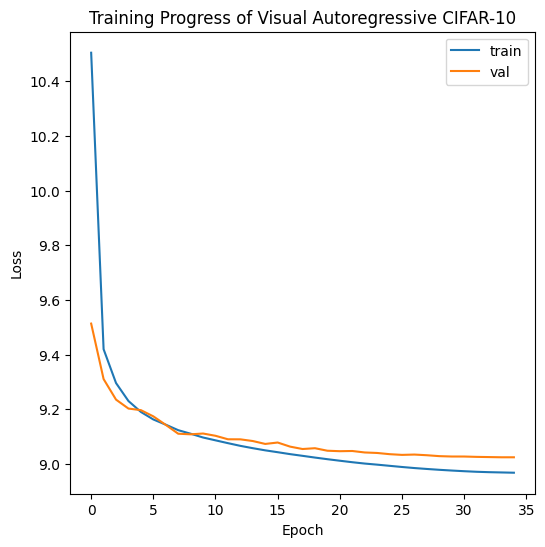

In [8]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress of Visual Autoregressive CIFAR-10')
plt.legend()
plt.show()

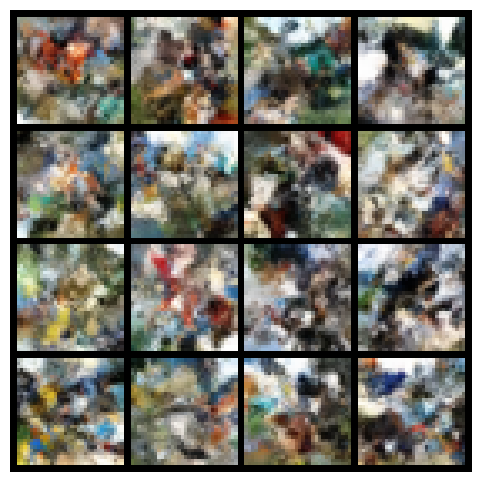

In [9]:
@torch.no_grad()
def sample_grid(model: VisualAutoregressiveCIFAR10, vqvae: ScaleVQVAE, n: int = 16):
    model.eval()
    indices_levels = model.sample(batch_size=n, device=device, vqvae=vqvae)
    decoded = vqvae.decode_from_indices(indices_levels[-1])
    grid = make_grid(decoded, nrow=int(math.sqrt(n)), padding=2, normalize=False)
    return grid.permute(1, 2, 0)

grid = sample_grid(model, vqvae, n=16).cpu()
plt.figure(figsize=(6, 6))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [11]:
import numpy as np
from scipy import linalg
from torchvision.models import inception_v3
from torchvision.transforms.functional import resize


class InceptionFeatureExtractor(nn.Module):
    """Extract features from Inception V3 for FID calculation."""
    def __init__(self, device='cuda'):
        super().__init__()
        from torchvision.models import Inception_V3_Weights
        inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False)
        inception = inception.to(device)
        inception.eval()

        # Extract features before the final avgpool and fc layers
        self.features = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2).to(device),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2).to(device),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
            nn.AdaptiveAvgPool2d((1, 1)).to(device)
        ).to(device)

        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Inception expects 3-channel input and 299x299 resolution
        if x.shape[-1] != 299:
            x = resize(x, [299, 299])
        x = self.features(x)
        return x.view(x.size(0), -1)


def calculate_activation_statistics(images, feature_extractor, device, batch_size=50):
    """Calculate mean and covariance of features."""
    feature_extractor.eval()
    n_images = len(images)
    n_batches = (n_images + batch_size - 1) // batch_size

    features_list = []
    with torch.no_grad():
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, n_images)
            batch = images[start_idx:end_idx].to(device)
            features = feature_extractor(batch)
            features_list.append(features.cpu().numpy())

    features = np.concatenate(features_list, axis=0)
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma


def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate Fréchet Inception Distance between two distributions."""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2
    # Initialize feature extractor with device
    feature_extractor = InceptionFeatureExtractor(device=device)
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError(f'Imaginary component {m}')
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return fid


@torch.no_grad()
def compute_fid_score(model, vqvae, real_loader, device, n_samples=10000):
    """Compute FID score between real and generated images."""
    print('Computing FID score...')

    # Initialize feature extractor
    feature_extractor = InceptionFeatureExtractor().to(device)

    # Collect real images
    real_images = []
    for levels, _ in real_loader:
        real_images.append(levels[-1])
        if sum(img.shape[0] for img in real_images) >= n_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:n_samples]

    print(f'Calculating statistics for {len(real_images)} real images...')
    mu_real, sigma_real = calculate_activation_statistics(real_images, feature_extractor, device)

    # Generate samples
    print(f'Generating {n_samples} samples...')
    generated_images = []
    batch_size = 100
    n_batches = (n_samples + batch_size - 1) // batch_size

    model.eval()
    for _ in tqdm(range(n_batches), desc='Generating samples'):
        current_batch_size = min(batch_size, n_samples - len(generated_images) * batch_size)
        if current_batch_size <= 0:
            break
        indices_levels = model.sample(batch_size=current_batch_size, device=device, vqvae=vqvae)
        decoded = vqvae.decode_from_indices(indices_levels[-1])
        generated_images.append(decoded.cpu())

    generated_images = torch.cat(generated_images, dim=0)[:n_samples]

    print(f'Calculating statistics for {len(generated_images)} generated images...')
    mu_gen, sigma_gen = calculate_activation_statistics(generated_images, feature_extractor, device)

    # Calculate FID
    fid_score = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
    print(f'FID Score: {fid_score:.2f}')

    return fid_score


# Compute FID score
fid = compute_fid_score(model, vqvae, test_loader, device, n_samples=10000)

Computing FID score...
Calculating statistics for 10000 real images...
Generating 10000 samples...


Generating samples:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating statistics for 10000 generated images...


/tmp/ipython-input-3450270491.py:81: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


FID Score: 194.15


## FID Score Evaluation
Evaluate the quality of generated CIFAR-10 samples using Fréchet Inception Distance (FID).

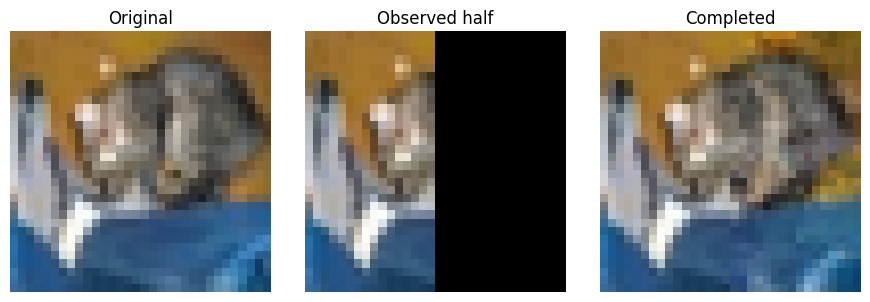

Completed right-half pixels conditioned on left-half observation using VQ-VAE codes.


In [12]:
# Conditional completion with VQ-VAE codes: fix left half and autoregressively fill the right half
model.eval()
coarse_levels, test_label = test_dataset[0]
levels = [level.unsqueeze(0) for level in coarse_levels]
with torch.no_grad():
    level_indices, conditionings = prepare_autoregressive_inputs(levels, vqvae, device)
    logits_levels = model(conditionings)
    final_logits = logits_levels[-1]
    probs = torch.softmax(final_logits, dim=1)
    dist = torch.distributions.Categorical(probs.permute(0, 2, 3, 1).reshape(-1, vqvae.codebook_size))
    sampled = dist.sample().view_as(level_indices[-1])

completed_indices = level_indices[-1].clone()
half_cols = completed_indices.shape[-1] // 2
completed_indices[:, :, half_cols:] = sampled[:, :, half_cols:]

with torch.no_grad():
    original = vqvae.decode_from_indices(level_indices[-1])
    completed_image = vqvae.decode_from_indices(completed_indices)

mask = torch.zeros_like(original)
mask[:, :, :, :half_cols] = 1.0
observed = original * mask
combined = completed_image * (1.0 - mask) + observed

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(original.squeeze(0).permute(1, 2, 0).cpu())
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(observed.squeeze(0).permute(1, 2, 0).cpu())
axes[1].set_title('Observed half')
axes[1].axis('off')
axes[2].imshow(combined.squeeze(0).permute(1, 2, 0).cpu())
axes[2].set_title('Completed')
axes[2].axis('off')
plt.tight_layout()
plt.show()

print('Completed right-half pixels conditioned on left-half observation using VQ-VAE codes.')

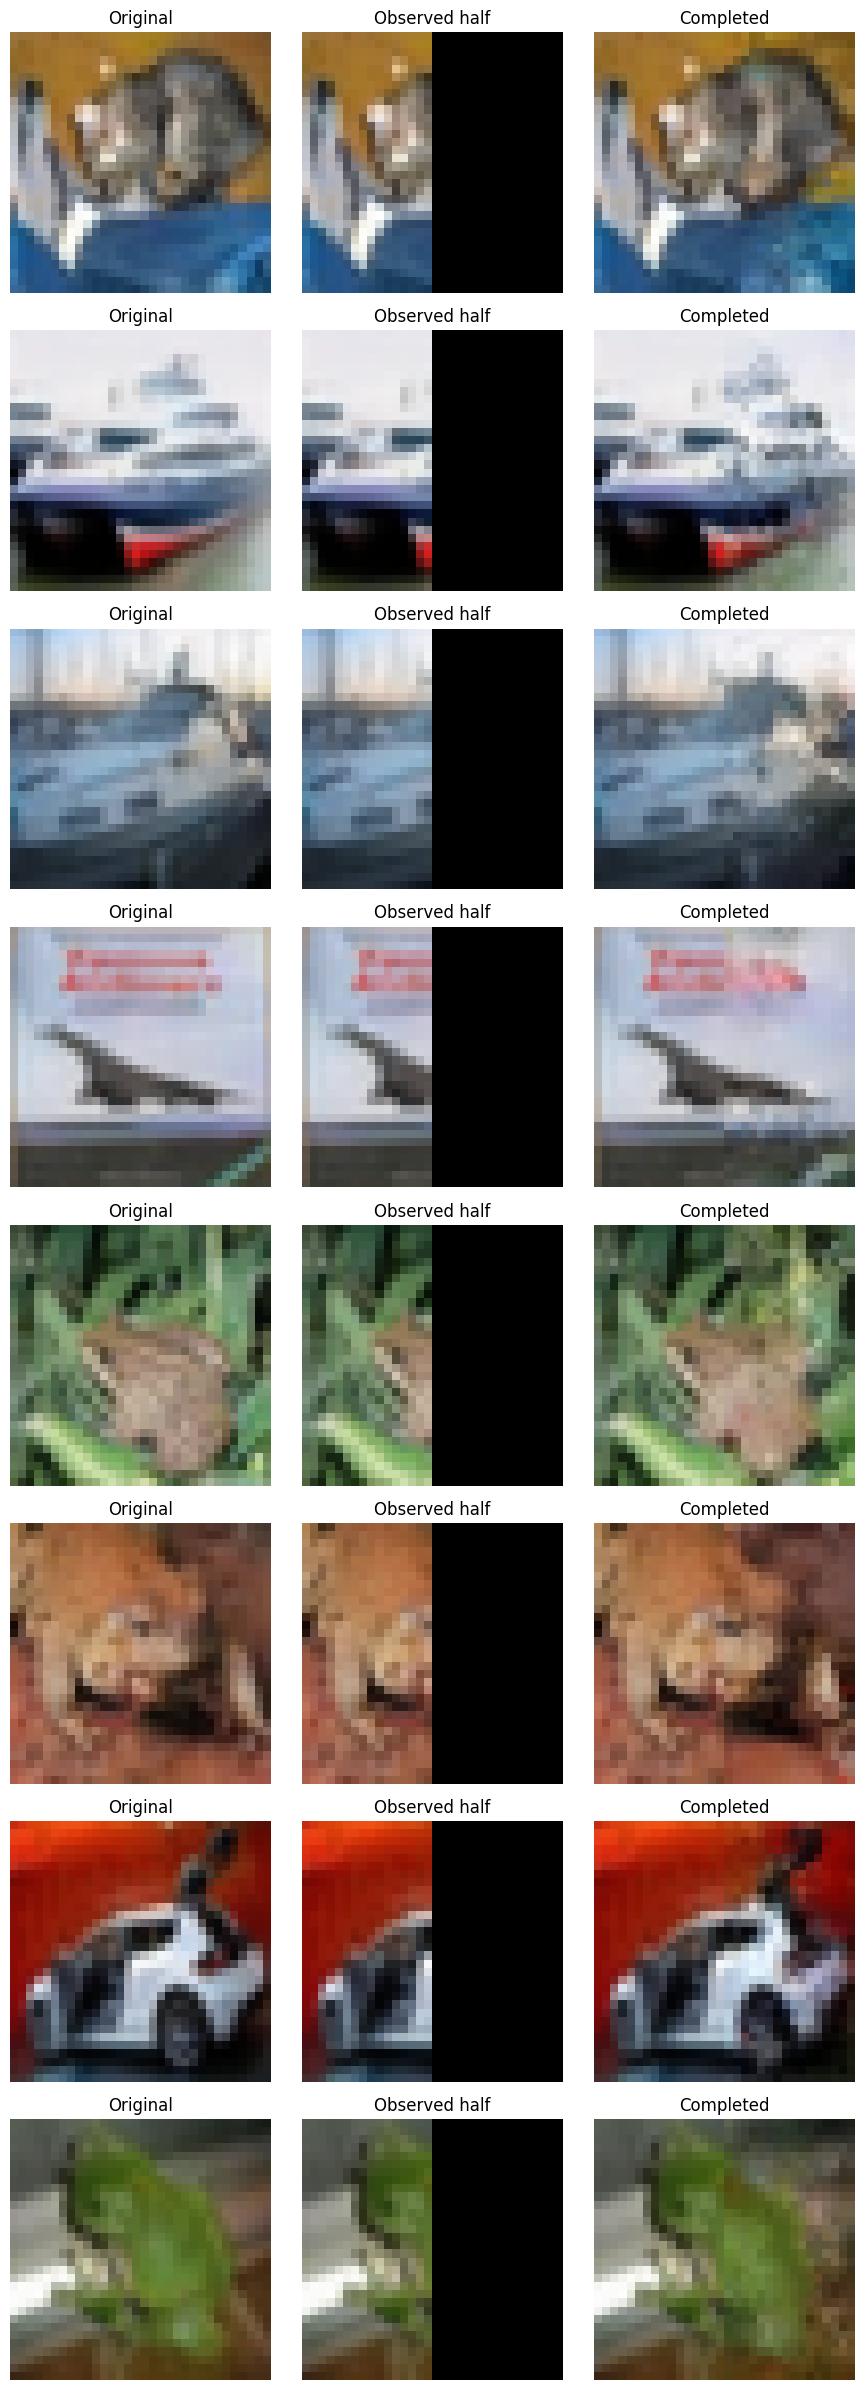

Completed right-half pixels for 8 test images conditioned on left-half observation using VQ-VAE codes.


In [13]:
# Conditional completion for multiple test images (left half fixed)
model.eval()
n = 8
batch_pyramids = [test_dataset[i][0] for i in range(n)]
levels = [torch.stack([pyramid[level_idx] for pyramid in batch_pyramids], dim=0) for level_idx in range(len(scales))]
with torch.no_grad():
    level_indices, conditionings = prepare_autoregressive_inputs(levels, vqvae, device)
    logits_levels = model(conditionings)
    final_logits = logits_levels[-1]
    probs = torch.softmax(final_logits, dim=1)
    dist = torch.distributions.Categorical(probs.permute(0, 2, 3, 1).reshape(-1, vqvae.codebook_size))
    sampled = dist.sample().view(n, scales[-1], scales[-1])

completed_indices = level_indices[-1].clone()
half_cols = completed_indices.shape[-1] // 2
completed_indices[:, :, half_cols:] = sampled[:, :, half_cols:]

with torch.no_grad():
    original = vqvae.decode_from_indices(level_indices[-1])
    completed_images = vqvae.decode_from_indices(completed_indices)

mask = torch.zeros_like(original)
mask[:, :, :, :half_cols] = 1.0
observed = original * mask
combined = completed_images * (1.0 - mask) + observed

fig, axes = plt.subplots(n, 3, figsize=(9, 3 * n))
for i in range(n):
    axes[i, 0].imshow(original[i].permute(1, 2, 0).cpu())
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(observed[i].permute(1, 2, 0).cpu())
    axes[i, 1].set_title('Observed half')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(combined[i].permute(1, 2, 0).cpu())
    axes[i, 2].set_title('Completed')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print(f'Completed right-half pixels for {n} test images conditioned on left-half observation using VQ-VAE codes.')

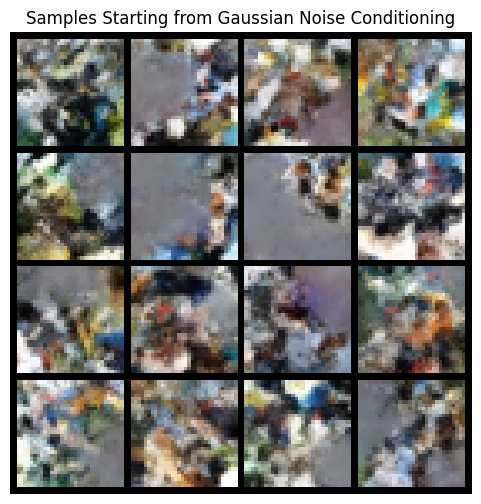

In [14]:
# Sample images by seeding the autoregressive model with Gaussian noise instead of zeros.
@torch.no_grad()
def sample_from_gaussian_noise(model: VisualAutoregressiveCIFAR10, vqvae: ScaleVQVAE, n: int = 16, noise_std: float = 1.0):
    model.eval()
    conditioning = torch.randn((n, 3, scales[0], scales[0]), device=device) * noise_std
    samples: List[torch.Tensor] = []
    for level, (size, block) in enumerate(zip(scales, model.blocks)):
        logits = block(conditioning)
        probs = torch.softmax(logits, dim=1)
        dist = torch.distributions.Categorical(probs.permute(0, 2, 3, 1).reshape(-1, model.codebook_size))
        sampled = dist.sample().view(n, size, size)
        samples.append(sampled)
        if level + 1 < len(scales):
            decoded = vqvae.decode_from_indices(sampled)
            conditioning = F.interpolate(decoded, size=(scales[level + 1], scales[level + 1]), mode='nearest')
    decoded = vqvae.decode_from_indices(samples[-1])
    grid = make_grid(decoded, nrow=int(math.sqrt(n)), padding=2, normalize=False)
    return grid.permute(1, 2, 0).cpu()

noise_grid = sample_from_gaussian_noise(model, vqvae, n=16, noise_std=1.0)
plt.figure(figsize=(6, 6))
plt.imshow(noise_grid)
plt.axis('off')
plt.title('Samples Starting from Gaussian Noise Conditioning')
plt.show()

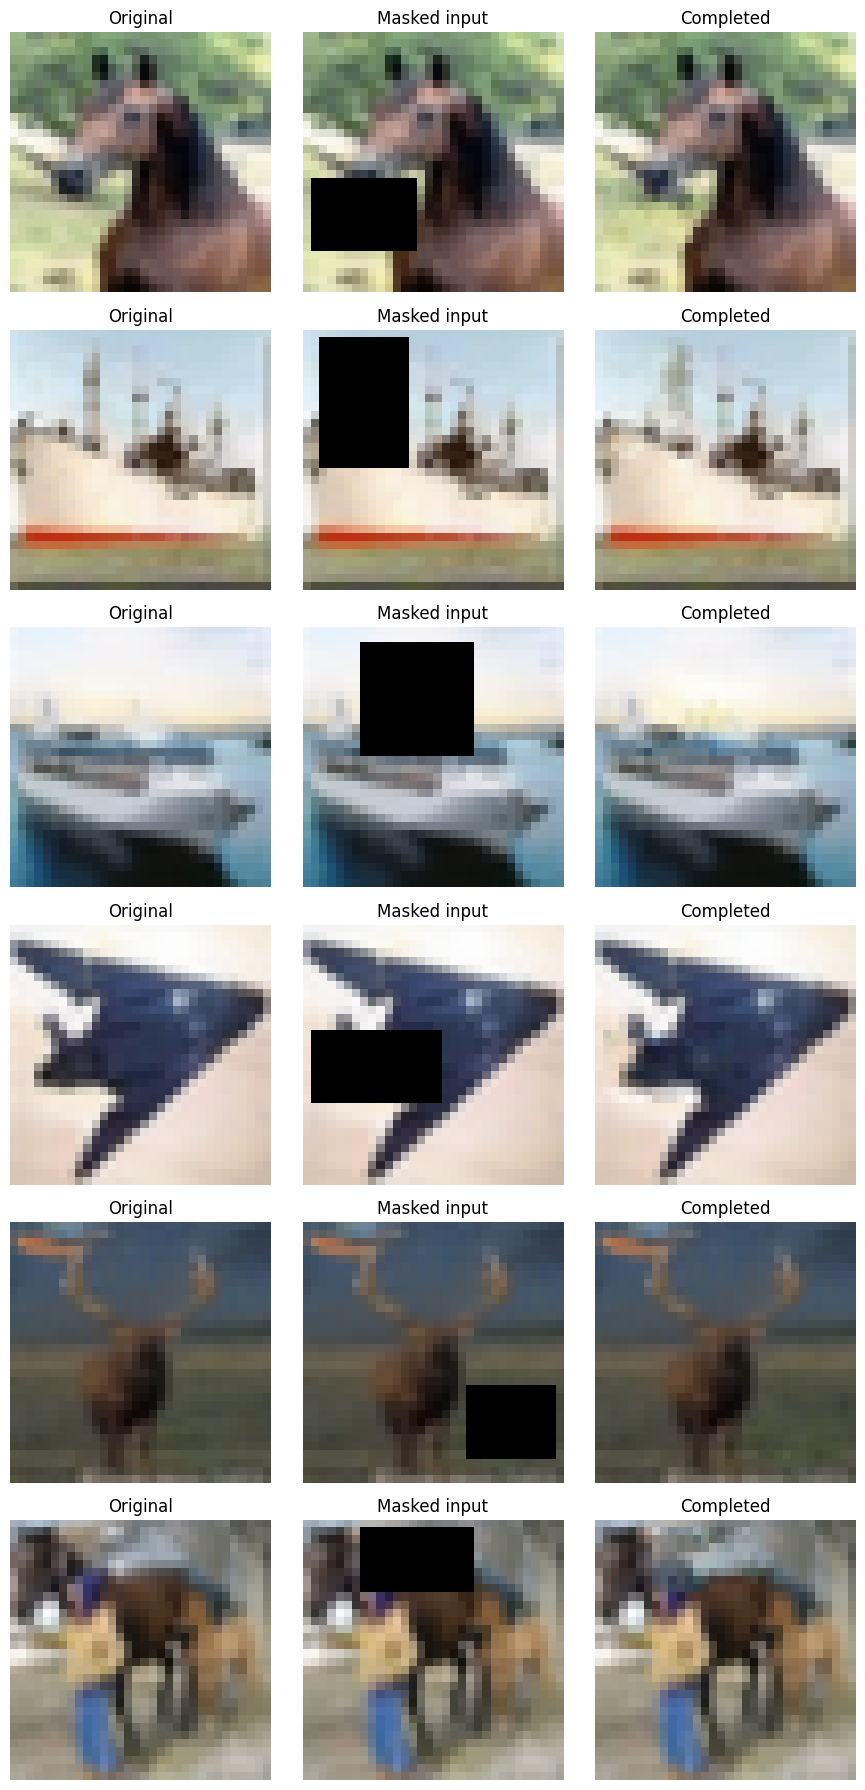

Completed random masked regions for 6 samples using the autoregressive model.


In [15]:
# Random mask inpainting: hide random rectangles and let the model complete them.
@torch.no_grad()
def inpaint_random_masks(model: VisualAutoregressiveCIFAR10, vqvae: ScaleVQVAE, dataset: Dataset, n: int = 6, min_box: int = 8, max_box: int = 16):
    model.eval()
    size = scales[-1]
    max_box = min(max_box, size)
    min_box = max(1, min(min_box, max_box))

    chosen = random.sample(range(len(dataset)), n)
    batch_pyramids = [dataset[i][0] for i in chosen]
    levels = [torch.stack([pyramid[level_idx] for pyramid in batch_pyramids], dim=0) for level_idx in range(len(scales))]

    level_indices, conditionings = prepare_autoregressive_inputs(levels, vqvae, device)
    logits_levels = model(conditionings)
    final_logits = logits_levels[-1]
    probs = torch.softmax(final_logits, dim=1)
    dist = torch.distributions.Categorical(probs.permute(0, 2, 3, 1).reshape(-1, vqvae.codebook_size))
    sampled = dist.sample().view(n, size, size)

    mask = torch.ones((n, 1, size, size), device=device)
    for i in range(n):
        box_h = random.randint(min_box, max_box)
        box_w = random.randint(min_box, max_box)
        top = random.randint(0, size - box_h)
        left = random.randint(0, size - box_w)
        mask[i, :, top:top + box_h, left:left + box_w] = 0.0

    completed_indices = level_indices[-1].clone()
    missing = mask.squeeze(1) == 0
    completed_indices[missing] = sampled[missing]

    original = vqvae.decode_from_indices(level_indices[-1])
    completed = vqvae.decode_from_indices(completed_indices)

    mask_float = mask.to(original.dtype)
    observed = original * mask_float
    combined = completed * (1.0 - mask_float) + observed

    fig, axes = plt.subplots(n, 3, figsize=(9, 3 * n))
    if n == 1:
        axes = axes.reshape(1, -1)
    for idx in range(n):
        axes[idx, 0].imshow(original[idx].permute(1, 2, 0).cpu())
        axes[idx, 0].set_title('Original')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(observed[idx].permute(1, 2, 0).cpu())
        axes[idx, 1].set_title('Masked input')
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(combined[idx].permute(1, 2, 0).cpu())
        axes[idx, 2].set_title('Completed')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()
    print(f'Completed random masked regions for {n} samples using the autoregressive model.')

inpaint_random_masks(model, vqvae, test_dataset, n=6, min_box=8, max_box=16)